In [4]:
import pandas as pd
import numpy as np
from sklearn import *
import texthero

# Data

In [8]:
path = 'data/train_40k.csv'

df_raw = pd.read_csv(path)
df = df_raw[['Title', 'Text', 'Cat1', 'Cat2']]


In [9]:
df.Cat1.value_counts()

toys games              10266
health personal care     9772
beauty                   5846
baby products            5637
pet supplies             4862
grocery gourmet food     3617
Name: Cat1, dtype: int64

In [10]:
print(df.loc[0, 'Cat1'])
print(df.loc[0, 'Text'])

grocery gourmet food
The description and photo on this product needs to be changed to indicate this product is the BuffalOs version of this beef jerky.


## Data preparation

For cleaning the data i'm going to experiment with a new library: __texthero__. It provides lots of functionallity, but ill simply start of by using its ``clean`` function, which very easily can be used together with pandas' pipe - just like this:

In [11]:
df['cleaned_text'] = df['Text'].pipe(texthero.clean); df.head()

<ipython-input-11-f06a93abee21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['Text'].pipe(texthero.clean); df.head()


,Title,Text,Cat1,Cat2,cleaned_text
0,Golden Valley Natural Buffalo Jerky,The description and photo on this product need...,grocery gourmet food,meat poultry,description photo product needs changed indica...
1,Westing Game,This was a great book!!!! It is well thought t...,toys games,games,great book well thought easily imagine events ...
2,Westing Game,"I am a first year teacher, teaching 5th grade....",toys games,games,first year teacher teaching 5th grade special ...
3,Westing Game,I got the book at my bookfair at school lookin...,toys games,games,got book bookfair school looking something sum...
4,I SPY A is For Jigsaw Puzzle 63pc,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,hi martine redman created puzzle briarpatch us...


A quick comparision between before and after

In [12]:
print(df.loc[0, 'Text'])
print()
print(df.loc[0, "cleaned_text"])

The description and photo on this product needs to be changed to indicate this product is the BuffalOs version of this beef jerky.

description photo product needs changed indicate product buffalos version beef jerky


What it seems to do:
- lowercase
- (english) stopword removal
- punctuation removal

... what it actually does (from the [documentation](https://texthero.org/docs/getting-started#preprocessing)):
- fillna(s) Replace not assigned values with empty spaces.
- lowercase(s) Lowercase all text.
- remove_digits() Remove all blocks of digits.
- remove_punctuation() Remove all string.punctuation (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~).
- remove_diacritics() Remove all accents from strings.
- remove_stopwords() Remove all stop words.
- remove_whitespace() Remove all white space between words.

This might be a better example of what it does for you:

In [13]:
mini_df = pd.DataFrame(data=[{"text": 'This Is a SenténCe with  \n\n  random. stuff 123 like what?! Car industry important'}])
mini_df['clean'] = mini_df['text'].pipe(texthero.clean)
mini_df.loc[0]['clean']

'sentence random stuff like car industry important'

# Classifiers
1. Single classifier on concatenation of Cat1 and Cat2 (labels is the joint labels from the two categories)
2. Two layer classifier where prediction is made independently
3. Two kayer classifier hierarchy where each Cat1 gets its own sub-classifier. Prediction is made sequentially


## 1. Concatenation of category and subcategory labels
Create new column with concatenated labels

In [14]:
df["concat_labels"] = df.apply(lambda row: "/".join([row['Cat1'], row['Cat2']]), axis = 1)

<ipython-input-14-19989a90904f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["concat_labels"] = df.apply(lambda row: "/".join([row['Cat1'], row['Cat2']]), axis = 1)


In [15]:
df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels
0,Golden Valley Natural Buffalo Jerky,The description and photo on this product need...,grocery gourmet food,meat poultry,description photo product needs changed indica...,grocery gourmet food/meat poultry
1,Westing Game,This was a great book!!!! It is well thought t...,toys games,games,great book well thought easily imagine events ...,toys games/games
2,Westing Game,"I am a first year teacher, teaching 5th grade....",toys games,games,first year teacher teaching 5th grade special ...,toys games/games
3,Westing Game,I got the book at my bookfair at school lookin...,toys games,games,got book bookfair school looking something sum...,toys games/games
4,I SPY A is For Jigsaw Puzzle 63pc,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,hi martine redman created puzzle briarpatch us...,toys games/puzzles


Let's get a feel for the distribution of these categories

In [16]:
df.concat_labels.value_counts()

health personal care/personal care         2852
pet supplies/dogs                          2610
health personal care/nutrition wellness    2203
health personal care/health care           2002
pet supplies/cats                          1779
                                           ... 
grocery gourmet food/baby food               40
grocery gourmet food/sauces dips             40
grocery gourmet food/produce                 38
grocery gourmet food/meat seafood            37
pet supplies/small animals                   29
Name: concat_labels, Length: 64, dtype: int64

In [17]:
len(df.concat_labels.unique())

64

Time to train the classifier model. We're gonna use an sklearn pipeline to combine the tfidf embedding step togeter with a linear SVM classifier. 

In [92]:
from sklearn.neural_network import MLPClassifier
def get_test_train_split(dataframe):
    return model_selection.train_test_split(df, train_size=0.8, random_state=1)

def get_base_pipeline():
    return pipeline.Pipeline(steps = [
        ("tfidf", feature_extraction.text.TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=[1,1], max_features=4096, sublinear_tf=True)),
        ("svc", svm.LinearSVC(class_weight='balanced'))
    ])

def get_mlp_pipeline():
    return pipeline.Pipeline(steps = [
        ("tfidf", feature_extraction.text.TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=[1,1], max_features=4096, sublinear_tf=True)),
        ("mlp", MLPClassifier(hidden_layer_sizes=(1024, 128), early_stopping=True, verbose=1))
    ])
    
train_df, test_df = get_test_train_split(df)

In [28]:
clf_concatenated_labels_1 = get_base_pipeline()

clf_concatenated_labels_1.fit(train_df['cleaned_text'], train_df["concat_labels"])
print(metrics.classification_report(test_df["concat_labels"], clf_concatenated_labels_1.predict(test_df['cleaned_text'])))

                                                       precision    recall  f1-score   support

                      baby products/bathing skin care       0.33      0.54      0.41        65
                  baby products/car seats accessories       0.58      0.74      0.65        73
                              baby products/diapering       0.79      0.77      0.78       221
                                baby products/feeding       0.68      0.72      0.70       191
                                   baby products/gear       0.52      0.56      0.54       138
                                  baby products/gifts       0.18      0.37      0.24        27
                       baby products/health baby care       0.08      0.17      0.11        12
                                baby products/nursery       0.47      0.42      0.44       178
                         baby products/potty training       0.49      0.79      0.61        29
                    baby products/pregnancy mater

In [26]:
clf_concatenated_labels_2 = get_mlp_pipeline()

clf_concatenated_labels_2.fit(train_df['cleaned_text'], train_df["concat_labels"])
print(metrics.classification_report(test_df["concat_labels"], clf_concatenated_labels_2.predict(test_df['cleaned_text'])))

Iteration 1, loss = 2.86787633
Validation score: 0.486563
Iteration 2, loss = 1.77042433
Validation score: 0.527188
Iteration 3, loss = 1.54327315
Validation score: 0.540000
Iteration 4, loss = 1.41753456
Validation score: 0.538438
Iteration 5, loss = 1.32105952
Validation score: 0.535937
Iteration 6, loss = 1.23497858
Validation score: 0.535000
Iteration 7, loss = 1.15399950
Validation score: 0.538438
Iteration 8, loss = 1.08024838
Validation score: 0.533750
Iteration 9, loss = 1.00433918
Validation score: 0.527188
Iteration 10, loss = 0.92739410
Validation score: 0.530937
Iteration 11, loss = 0.85211277
Validation score: 0.520938
Iteration 12, loss = 0.77139991
Validation score: 0.522500
Iteration 13, loss = 0.69100946
Validation score: 0.520312
Iteration 14, loss = 0.60560581
Validation score: 0.520625
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
                                                       precision    recall  f1-score   sup

/Users/Viktor/miniconda3/envs/hier-clf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Well this wasn't particularly impressive. We did however only use one of the available text fields `Text`, let's see what happens if use the `Title` instead.

In [18]:
df['cleaned_title'] = df['Title'].pipe(texthero.clean); df.head()

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title
0,Golden Valley Natural Buffalo Jerky,The description and photo on this product need...,grocery gourmet food,meat poultry,description photo product needs changed indica...,grocery gourmet food/meat poultry,golden valley natural buffalo jerky
1,Westing Game,This was a great book!!!! It is well thought t...,toys games,games,great book well thought easily imagine events ...,toys games/games,westing game
2,Westing Game,"I am a first year teacher, teaching 5th grade....",toys games,games,first year teacher teaching 5th grade special ...,toys games/games,westing game
3,Westing Game,I got the book at my bookfair at school lookin...,toys games,games,got book bookfair school looking something sum...,toys games/games,westing game
4,I SPY A is For Jigsaw Puzzle 63pc,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,hi martine redman created puzzle briarpatch us...,toys games/puzzles,spy jigsaw puzzle 63pc


In [19]:
train_df, test_df = get_test_train_split(df)
clf_concatenated_labels_1.fit(train_df['cleaned_title'], train_df["concat_labels"])
print(metrics.classification_report(test_df["concat_labels"], clf_concatenated_labels_1.predict(test_df['cleaned_title'])))

                                                       precision    recall  f1-score   support

                      baby products/bathing skin care       0.90      0.85      0.87        65
                  baby products/car seats accessories       0.97      0.89      0.93        73
                              baby products/diapering       0.96      0.99      0.97       221
                                baby products/feeding       0.96      0.97      0.96       191
                                   baby products/gear       0.93      0.89      0.91       138
                                  baby products/gifts       0.96      0.89      0.92        27
                       baby products/health baby care       0.75      0.75      0.75        12
                                baby products/nursery       0.96      0.94      0.95       178
                         baby products/potty training       0.96      0.93      0.95        29
                    baby products/pregnancy mater

Apperently, titles answer the question of which category the reviews are in much better than the description.

In [20]:
df[["cleaned_title", "concat_labels"]].head(25)

,cleaned_title,concat_labels
0,golden valley natural buffalo jerky,grocery gourmet food/meat poultry
1,westing game,toys games/games
2,westing game,toys games/games
3,westing game,toys games/games
4,spy jigsaw puzzle 63pc,toys games/puzzles
5,thinkfun rush hour,toys games/games
6,beetle juice,grocery gourmet food/beverages
7,beetle juice vhs,grocery gourmet food/beverages
8,boundaries,beauty/makeup
9,crayola 120ct original crayons,toys games/arts crafts


It's almost too easy to perform predictions with the title. To leave room for improvement - i'll focus on performing perdictions based on the text rather than the title. 

Before we move on the the second classifier - its worth considering how to measure performance. In the above example we calculated the accuracy for the entire prediction task as _how often do we get both category and its subcategory prediction correct._ To better understand the systems performance, I think its better to split these two prediction tasks (category and subcategory) into two. 

In [21]:
test_df['clf1_cat1_cat2_preds'] = test_df['cleaned_text'].pipe(clf_concatenated_labels_1.predict)
test_df['clf1_cat1_preds'] = test_df['clf1_cat1_cat2_preds'].apply(lambda row: row.split('/')[0])
test_df['clf1_cat2_preds'] = test_df['clf1_cat1_cat2_preds'].apply(lambda row: row.split('/')[1])

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [22]:
test_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,clf1_cat1_cat2_preds,clf1_cat1_preds,clf1_cat2_preds
3841,Summer Infant Complete Nursery Care Kit,I received this kit as a gift and I actually u...,baby products,bathing skin care,received kit gift actually use quite bit produ...,baby products/bathing skin care,summer infant complete nursery care kit,grocery gourmet food/gourmet gifts,grocery gourmet food,gourmet gifts
12898,Andis Ceramic Clamp Flat Iron,I love my Andis Flat Iron! I initially bought ...,beauty,hair care,love andis flat iron initially bought amazon f...,beauty/hair care,andis ceramic clamp flat iron,beauty/hair care,beauty,hair care
15032,"Splenda No Calorie Sweetener Granular, Individ...","As I use alot of Splenda, this was a great $$ ...",grocery gourmet food,cooking baking supplies,use alot splenda great deal bulk purchase comp...,grocery gourmet food/cooking baking supplies,splenda calorie sweetener granular individual ...,toys games/games,toys games,games
36781,Pampers Baby Dry Diapers (Packaging May Vary),Tried a lot of brands and found these to be th...,baby products,diapering,tried lot brands found best gripe seem fit 17l...,baby products/diapering,pampers baby dry diapers packaging may vary,toys games/learning education,toys games,learning education
9201,Camille Beckman Glycerine Hand Therapy,"I've smelled the Vanilla, Orange, Vanilla Spic...",beauty,skin care,smelled vanilla orange vanilla spice others so...,beauty/skin care,camille beckman glycerine hand therapy,beauty/skin care,beauty,skin care


In [23]:
print(metrics.classification_report(test_df["Cat1"], test_df["clf1_cat1_preds"]))
print(metrics.classification_report(test_df["Cat2"], test_df["clf1_cat2_preds"]))

                      precision    recall  f1-score   support

       baby products       0.77      0.65      0.70      1161
              beauty       0.67      0.74      0.70      1129
grocery gourmet food       0.66      0.70      0.68       724
health personal care       0.73      0.64      0.68      1946
        pet supplies       0.85      0.72      0.78       957
          toys games       0.67      0.80      0.73      2083

            accuracy                           0.71      8000
           macro avg       0.72      0.71      0.71      8000
        weighted avg       0.72      0.71      0.71      8000

                                  precision    recall  f1-score   support

              action toy figures       0.41      0.44      0.43       227
                     arts crafts       0.25      0.48      0.33        67
                 baby child care       0.31      0.14      0.20        28
                       baby food       1.00      0.15      0.27        13
      

/Users/Viktor/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Now we have a baseline for the classifier performance for each level individually - this leads us nicely into the second classifier we want to experiment with.

# 2. Two levels of classification
Instead of training a single classifier to perform both layers of predictions at once - lets see what happens if we train two classifiers, one for each level of the hierarchy. This method is in other work described as "Classifier per Layer"

In [93]:
from scipy.stats import spearmanr
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline

def method_exists(instance, method):
    return hasattr(instance, method) and callable(instance.method)

def decition_func_to_max_prob(clf, x):
    return np.max(softmax(clf.decision_function([x])))
    

def test_cat1(clf):
    if clf.steps[1][0] == 'mlp':
        test_df['max_prob'] = test_df.cleaned_text.apply(lambda x: np.max(clf.predict_proba([x])))
    else: 
        test_df['max_prob'] = test_df.cleaned_text.apply(lambda x: decition_func_to_max_prob(clf, x))
    test_df['pred'] = test_df.cleaned_text.pipe(clf2_top_2.predict)
    test_df['correct'] = test_df.apply(lambda x: int(x["Cat1"]==x["pred"]), axis=1)
    
    test_df.max_prob, test_df.correct
    print(spearmanr(test_df.max_prob, test_df.correct))

    correct_pred_probs = test_df[test_df.correct == 1].max_prob
    incorrect_pred_probs = test_df[test_df.correct == 0].max_prob

    plt.hist(correct_pred_probs,  bins=20, log=True)
    plt.hist(incorrect_pred_probs, alpha=0.5, bins=20)

In [94]:
clf2_top_2 = get_mlp_pipeline()
clf2_top_2.fit(train_df.cleaned_text, train_df.Cat1)

Iteration 1, loss = 0.76922163
Validation score: 0.827187
Iteration 2, loss = 0.33966511
Validation score: 0.814375
Iteration 3, loss = 0.24495504
Validation score: 0.806562
Iteration 4, loss = 0.16877394
Validation score: 0.803438
Iteration 5, loss = 0.09825631
Validation score: 0.800000
Iteration 6, loss = 0.04742140
Validation score: 0.798125
Iteration 7, loss = 0.02245947
Validation score: 0.798438
Iteration 8, loss = 0.01334901
Validation score: 0.799063
Iteration 9, loss = 0.00990374
Validation score: 0.799687
Iteration 10, loss = 0.00924723
Validation score: 0.796562
Iteration 11, loss = 0.00852766
Validation score: 0.799687
Iteration 12, loss = 0.00770104
Validation score: 0.796875
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4096, min_df=2,
                                 ngram_range=[1, 1], sublinear_tf=True)),
                ('mlp',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(1024, 128), verbose=1))])

<ipython-input-89-f3885188b4ed>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['max_prob'] = test_df.cleaned_text.apply(lambda x: np.max(clf.predict_proba([x])))
<ipython-input-89-f3885188b4ed>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = test_df.cleaned_text.pipe(clf2_top_2.predict)
<ipython-input-89-f3885188b4ed>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

SpearmanrResult(correlation=0.45217093520176366, pvalue=0.0)


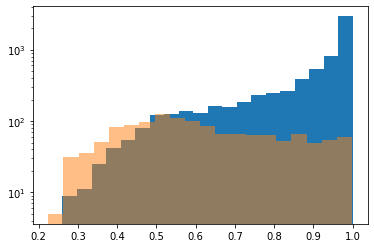

In [90]:
test_cat1(clf2_top_2)

In [ ]:
clf2_top_layer_1 = get_base_pipeline()
#clf2_bottom_layer_1 = get_base_pipeline()

clf2_top_layer_1.fit(train_df.cleaned_text, train_df.Cat1)
#clf2_bottom_layer_1.fit(train_df.cleaned_text, train_df.Cat2)

<ipython-input-89-f3885188b4ed>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['max_prob'] = test_df.cleaned_text.apply(lambda x: decition_func_to_max_prob(clf, x))
<ipython-input-89-f3885188b4ed>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = test_df.cleaned_text.pipe(clf2_top_2.predict)
<ipython-input-89-f3885188b4ed>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

SpearmanrResult(correlation=0.35076958799140595, pvalue=2.4130457523142782e-230)


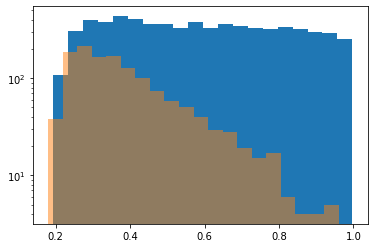

In [91]:
test_cat1(clf2_top_layer_1)

In [80]:
np.max(softmax(clf2_top_layer_1.decision_function(["this is a test"])))

0.5216002278603971

In [25]:
test_df['clf2_cat1_preds'] = test_df['cleaned_text'].pipe(clf2_top_layer_1.predict)
test_df['clf2_cat2_preds'] = test_df['cleaned_text'].pipe(clf2_bottom_layer_1.predict)

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
print(metrics.classification_report(test_df["Cat1"], test_df["clf2_cat1_preds"]))
print(metrics.classification_report(test_df["Cat2"], test_df["clf2_cat2_preds"]))

                      precision    recall  f1-score   support

       baby products       0.85      0.84      0.84      1161
              beauty       0.80      0.83      0.82      1129
grocery gourmet food       0.84      0.86      0.85       724
health personal care       0.80      0.80      0.80      1946
        pet supplies       0.92      0.85      0.89       957
          toys games       0.91      0.92      0.91      2083

            accuracy                           0.85      8000
           macro avg       0.85      0.85      0.85      8000
        weighted avg       0.85      0.85      0.85      8000

                                  precision    recall  f1-score   support

              action toy figures       0.61      0.58      0.59       227
                     arts crafts       0.59      0.57      0.58        67
                 baby child care       0.43      0.54      0.48        28
                       baby food       0.33      0.31      0.32        13
      

For the Cat1 labels we went from 71% to 86%, thats a significant improvement! Same goes for Cat2 predictions went from 53 to 67! Worth considering here is also that we aren't performing any hyperparameter optimisation, simply using some common sense ones together with the default.

Where can we go to improve from here? Well, there's a hierarchy to this classification problem! All cat2 classes can be grouped and related to a parent cat1 class! This connection is not taken into consideration in the above classifiers. They are entierly _independent_.

## 3. Dependent classifiers
The idea here is to have a single top level classifier predicting the cat1 class. Then, for each of the classes at this level, we train a second classifier which predicts the subcategories within each "family".

### 3.1 Let the top level decide first. 
this approach uses the top level classifier to select the first class, and based on this decition procedes with the second classifier.

In [27]:
clf3_1_top_1 = get_base_pipeline()
cat1_classes = train_df.Cat1.unique()
clf3_1_top_1.fit(train_df.cleaned_text, train_df.Cat1)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=[1, 2],
                                 sublinear_tf=True)),
                ('svc', LinearSVC(class_weight='balanced'))])

In [28]:
clf3_1_bottom_1_dict = {}
for cat1 in cat1_classes:
    print(cat1)
    clf = get_base_pipeline()
    cat1_only_df = train_df.loc[df.Cat1 == cat1]
    clf.fit(cat1_only_df.cleaned_text, cat1_only_df.Cat2)
    clf3_1_bottom_1_dict[cat1] = clf

toys games
pet supplies
grocery gourmet food
beauty
health personal care
baby products


Lets first run the predictions using the top level classifier, then we use that prediction's bottom layer classifier to run the second prediction

In [29]:
test_df['clf3_1_cat1_preds'] = test_df.cleaned_text.pipe(clf3_1_top_1.predict); test_df.head()

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,clf1_cat1_cat2_preds,clf1_cat1_preds,clf1_cat2_preds,clf2_cat1_preds,clf2_cat2_preds,clf3_1_cat1_preds
3841,Summer Infant Complete Nursery Care Kit,I received this kit as a gift and I actually u...,baby products,bathing skin care,received kit gift actually use quite bit produ...,baby products/bathing skin care,summer infant complete nursery care kit,grocery gourmet food/gourmet gifts,grocery gourmet food,gourmet gifts,beauty,bathing skin care,beauty
12898,Andis Ceramic Clamp Flat Iron,I love my Andis Flat Iron! I initially bought ...,beauty,hair care,love andis flat iron initially bought amazon f...,beauty/hair care,andis ceramic clamp flat iron,beauty/hair care,beauty,hair care,beauty,hair care,beauty
15032,"Splenda No Calorie Sweetener Granular, Individ...","As I use alot of Splenda, this was a great $$ ...",grocery gourmet food,cooking baking supplies,use alot splenda great deal bulk purchase comp...,grocery gourmet food/cooking baking supplies,splenda calorie sweetener granular individual ...,toys games/games,toys games,games,grocery gourmet food,pantry staples,grocery gourmet food
36781,Pampers Baby Dry Diapers (Packaging May Vary),Tried a lot of brands and found these to be th...,baby products,diapering,tried lot brands found best gripe seem fit 17l...,baby products/diapering,pampers baby dry diapers packaging may vary,toys games/learning education,toys games,learning education,health personal care,household supplies,health personal care
9201,Camille Beckman Glycerine Hand Therapy,"I've smelled the Vanilla, Orange, Vanilla Spic...",beauty,skin care,smelled vanilla orange vanilla spice others so...,beauty/skin care,camille beckman glycerine hand therapy,beauty/skin care,beauty,skin care,beauty,fragrance,beauty


In [30]:
test_df["clf3_1_cat2_preds"] = test_df.apply(lambda x: clf3_1_bottom_1_dict[x['clf3_1_cat1_preds']].predict([x['cleaned_text']])[0], axis=1)

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
test_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,clf1_cat1_cat2_preds,clf1_cat1_preds,clf1_cat2_preds,clf2_cat1_preds,clf2_cat2_preds,clf3_1_cat1_preds,clf3_1_cat2_preds
3841,Summer Infant Complete Nursery Care Kit,I received this kit as a gift and I actually u...,baby products,bathing skin care,received kit gift actually use quite bit produ...,baby products/bathing skin care,summer infant complete nursery care kit,grocery gourmet food/gourmet gifts,grocery gourmet food,gourmet gifts,beauty,bathing skin care,beauty,skin care
12898,Andis Ceramic Clamp Flat Iron,I love my Andis Flat Iron! I initially bought ...,beauty,hair care,love andis flat iron initially bought amazon f...,beauty/hair care,andis ceramic clamp flat iron,beauty/hair care,beauty,hair care,beauty,hair care,beauty,hair care
15032,"Splenda No Calorie Sweetener Granular, Individ...","As I use alot of Splenda, this was a great $$ ...",grocery gourmet food,cooking baking supplies,use alot splenda great deal bulk purchase comp...,grocery gourmet food/cooking baking supplies,splenda calorie sweetener granular individual ...,toys games/games,toys games,games,grocery gourmet food,pantry staples,grocery gourmet food,pantry staples
36781,Pampers Baby Dry Diapers (Packaging May Vary),Tried a lot of brands and found these to be th...,baby products,diapering,tried lot brands found best gripe seem fit 17l...,baby products/diapering,pampers baby dry diapers packaging may vary,toys games/learning education,toys games,learning education,health personal care,household supplies,health personal care,household supplies
9201,Camille Beckman Glycerine Hand Therapy,"I've smelled the Vanilla, Orange, Vanilla Spic...",beauty,skin care,smelled vanilla orange vanilla spice others so...,beauty/skin care,camille beckman glycerine hand therapy,beauty/skin care,beauty,skin care,beauty,fragrance,beauty,skin care


In [32]:
print(metrics.classification_report(test_df["Cat1"], test_df["clf3_1_cat1_preds"]))
print(metrics.classification_report(test_df["Cat2"], test_df["clf3_1_cat2_preds"]))

                      precision    recall  f1-score   support

       baby products       0.85      0.84      0.84      1161
              beauty       0.80      0.83      0.82      1129
grocery gourmet food       0.84      0.86      0.85       724
health personal care       0.80      0.80      0.80      1946
        pet supplies       0.92      0.85      0.89       957
          toys games       0.91      0.92      0.91      2083

            accuracy                           0.85      8000
           macro avg       0.85      0.85      0.85      8000
        weighted avg       0.85      0.85      0.85      8000

                                  precision    recall  f1-score   support

              action toy figures       0.61      0.56      0.58       227
                     arts crafts       0.54      0.55      0.54        67
                 baby child care       0.56      0.50      0.53        28
                       baby food       0.62      0.38      0.48        13
      

The accuracy went down, not really what we wanted... 

What we can be happy about is that we aren't providing any impossible predictions atleast.  

The probable cause for why we got worse performance is the fact that errors compound. We are bound by the precision of the top level model. If it is wrong, then so will the second layer classifier. Is there a way we could prevent this? To find out the upper limit, let's see what happens if the top layer always would be correct by using the correct second layer classifier all the time.

In [33]:
test_df["clf3_1_cheating_cat2_preds"] = test_df.apply(lambda x: clf3_1_bottom_1_dict[x['Cat1']].predict([x['cleaned_text']])[0], axis=1)
print(metrics.classification_report(test_df["Cat2"], test_df["clf3_1_cheating_cat2_preds"]))

                                  precision    recall  f1-score   support

              action toy figures       0.64      0.57      0.61       227
                     arts crafts       0.59      0.60      0.59        67
                 baby child care       0.60      0.54      0.57        28
                       baby food       0.90      0.69      0.78        13
               baby toddler toys       0.53      0.66      0.59       212
                       bath body       0.71      0.49      0.58       112
               bathing skin care       0.77      0.78      0.78        65
                       beverages       0.83      0.90      0.87       168
                           birds       0.59      0.62      0.60        21
                   breads bakery       0.33      0.33      0.33        27
                 breakfast foods       0.58      0.66      0.61        58
                   building toys       0.57      0.60      0.58        97
            bunny rabbit central     

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



So in the best case scenario, where the top layer classifier is always right, the second layer is able to reach an accuracy of 74% (compared to 65% for the single classifier for the entire cat2). 

But that is what we should expect. A bunch of specialised classifiers, each only considering examples from within a single category, should be better than one classifier to rule them all. We want the system of first and second level classifiers to be able to achieve as close to this performance as possible. 

### 3.2 Dependent
Another approach we can take is to train the second level classifiers to be able to predict when a document does not belong to any of its subclasses. This could serve as a second layer of "defence" if the first layer classifier performs an incorrect prediction. 

To enable this, we need to create an "other" class which groups all instances outside the ones covered by this classifier. 

In [34]:
train_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title
21721,Little Tikes Discovery Camera Phone,My son seems to like this phone okay. But comp...,toys games,dress up pretend play,son seems like phone okay compared play phones...,toys games/dress up pretend play,little tikes discovery camera phone
15576,"KONG Classic Kong Dog Toy, Red","This is my dog's favorite, not only becuase it...",pet supplies,dogs,dog favorite becuase usually contain food boun...,pet supplies/dogs,kong classic kong dog toy red
28716,"Clif Shot Bloks Organic Energy Chews, 2.1-Ounc...",I take these on long runs. I typically don't e...,grocery gourmet food,snack food,take long runs typically eat go blocks curb hu...,grocery gourmet food/snack food,clif shot bloks organic energy chews ounce pac...
204,"Pure & Natural Hypoallergenic Bar Soap, 4.5 oz...",Winter is hard on my skin and we've had an exc...,beauty,bath body,winter hard skin exceptionally dry winter skin...,beauty/bath body,pure natural hypoallergenic bar soap oz ea
36677,Camille Beckman Hand & Shower Gel,I bought the 8oz White lilac shower gel and I ...,beauty,bath body,bought 8oz white lilac shower gel love foams r...,beauty/bath body,camille beckman hand shower gel


In [35]:
cat1_classes

array(['toys games', 'pet supplies', 'grocery gourmet food', 'beauty',
       'health personal care', 'baby products'], dtype=object)

In [36]:
def get_cat1_dataset_column(cat1):
    cat1_ = cat1.replace(" ", "_")
    return f'{cat1_}-relative_subcat'

def subcat_or_other(row, cat1_subcats):
    cat2 = row.Cat2
    return cat2 if cat2 in cat1_subcats else "other"

for cat1 in cat1_classes:
    cat1_subcats = train_df[train_df.Cat1 == cat1].Cat2.unique()
    train_df[get_cat1_dataset_column(cat1)] = train_df.apply(lambda row: subcat_or_other(row, cat1_subcats), axis=1)

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
train_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,toys_games-relative_subcat,pet_supplies-relative_subcat,grocery_gourmet_food-relative_subcat,beauty-relative_subcat,health_personal_care-relative_subcat,baby_products-relative_subcat
21721,Little Tikes Discovery Camera Phone,My son seems to like this phone okay. But comp...,toys games,dress up pretend play,son seems like phone okay compared play phones...,toys games/dress up pretend play,little tikes discovery camera phone,dress up pretend play,other,other,other,other,other
15576,"KONG Classic Kong Dog Toy, Red","This is my dog's favorite, not only becuase it...",pet supplies,dogs,dog favorite becuase usually contain food boun...,pet supplies/dogs,kong classic kong dog toy red,other,dogs,other,other,other,other
28716,"Clif Shot Bloks Organic Energy Chews, 2.1-Ounc...",I take these on long runs. I typically don't e...,grocery gourmet food,snack food,take long runs typically eat go blocks curb hu...,grocery gourmet food/snack food,clif shot bloks organic energy chews ounce pac...,other,other,snack food,other,other,other
204,"Pure & Natural Hypoallergenic Bar Soap, 4.5 oz...",Winter is hard on my skin and we've had an exc...,beauty,bath body,winter hard skin exceptionally dry winter skin...,beauty/bath body,pure natural hypoallergenic bar soap oz ea,other,other,other,bath body,other,other
36677,Camille Beckman Hand & Shower Gel,I bought the 8oz White lilac shower gel and I ...,beauty,bath body,bought 8oz white lilac shower gel love foams r...,beauty/bath body,camille beckman hand shower gel,other,other,other,bath body,other,other


In [38]:
clf3_2_top_1 = get_base_pipeline()
clf3_2_top_1.fit(train_df.cleaned_text, train_df.Cat1)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=[1, 2],
                                 sublinear_tf=True)),
                ('svc', LinearSVC(class_weight='balanced'))])

In [39]:
test_df["clf3_2_top_1_preds"] = test_df.cleaned_text.pipe(clf3_2_top_1.predict)
print(metrics.classification_report(test_df["Cat1"], test_df["clf3_2_top_1_preds"]))


                      precision    recall  f1-score   support

       baby products       0.85      0.84      0.84      1161
              beauty       0.80      0.83      0.82      1129
grocery gourmet food       0.84      0.86      0.85       724
health personal care       0.80      0.80      0.80      1946
        pet supplies       0.92      0.85      0.89       957
          toys games       0.91      0.92      0.91      2083

            accuracy                           0.85      8000
           macro avg       0.85      0.85      0.85      8000
        weighted avg       0.85      0.85      0.85      8000



/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This classifier's performance is unchanged - just as we would expect. Lets train the handful of sub classifiers

In [40]:
clf3_2_bottom_1_dict = {}
for cat1 in cat1_classes:
    print(cat1)
    clf = get_base_pipeline()
    clf.fit(train_df.cleaned_text, train_df[get_cat1_dataset_column(cat1)])
    clf3_2_bottom_1_dict[cat1] = clf

toys games
pet supplies
grocery gourmet food
beauty
health personal care
baby products


In [41]:
test_df["clf3_2_cat2_preds"] = test_df.apply(lambda x: clf3_2_bottom_1_dict[x['clf3_2_top_1_preds']].predict([x['cleaned_text']])[0], axis=1)

/Users/Viktor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
test_df[["Cat1", "Cat2", "clf3_2_top_1_preds", "clf3_2_cat2_preds"]]

,Cat1,Cat2,clf3_2_top_1_preds,clf3_2_cat2_preds
3841,baby products,bathing skin care,beauty,other
12898,beauty,hair care,beauty,hair care
15032,grocery gourmet food,cooking baking supplies,grocery gourmet food,pantry staples
36781,baby products,diapering,health personal care,other
9201,beauty,skin care,beauty,skin care
...,...,...,...,...
30258,grocery gourmet food,beverages,grocery gourmet food,beverages
20563,health personal care,health care,health personal care,health care
20275,health personal care,personal care,health personal care,other
10121,grocery gourmet food,baby food,grocery gourmet food,other


If we only consider the cases where both classifiers guessed something except for "other" (which we could consider a sign of uncertainty), this is the result we find:

In [43]:
not_other_test_df = test_df[test_df['clf3_2_cat2_preds'] != 'other']
not_other_test_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,clf1_cat1_cat2_preds,clf1_cat1_preds,clf1_cat2_preds,clf2_cat1_preds,clf2_cat2_preds,clf3_1_cat1_preds,clf3_1_cat2_preds,clf3_1_cheating_cat2_preds,clf3_2_top_1_preds,clf3_2_cat2_preds
12898,Andis Ceramic Clamp Flat Iron,I love my Andis Flat Iron! I initially bought ...,beauty,hair care,love andis flat iron initially bought amazon f...,beauty/hair care,andis ceramic clamp flat iron,beauty/hair care,beauty,hair care,beauty,hair care,beauty,hair care,hair care,beauty,hair care
15032,"Splenda No Calorie Sweetener Granular, Individ...","As I use alot of Splenda, this was a great $$ ...",grocery gourmet food,cooking baking supplies,use alot splenda great deal bulk purchase comp...,grocery gourmet food/cooking baking supplies,splenda calorie sweetener granular individual ...,toys games/games,toys games,games,grocery gourmet food,pantry staples,grocery gourmet food,pantry staples,pantry staples,grocery gourmet food,pantry staples
9201,Camille Beckman Glycerine Hand Therapy,"I've smelled the Vanilla, Orange, Vanilla Spic...",beauty,skin care,smelled vanilla orange vanilla spice others so...,beauty/skin care,camille beckman glycerine hand therapy,beauty/skin care,beauty,skin care,beauty,fragrance,beauty,skin care,skin care,beauty,skin care
21288,Uberstix Starter Set,My daughter wanted some building toys for Chri...,toys games,building toys,daughter wanted building toys christmas search...,toys games/building toys,uberstix starter set,toys games/hobbies,toys games,hobbies,toys games,building toys,toys games,building toys,building toys,toys games,building toys
8600,Melissa's Fresh Blood Oranges (4 lbs.),Why go to the supermarket to look for exotic f...,grocery gourmet food,produce,go supermarket look exotic fruits order meliss...,grocery gourmet food/produce,melissa fresh blood oranges lbs,toys games/stuffed animals plush,toys games,stuffed animals plush,grocery gourmet food,fresh flowers live indoor plants,grocery gourmet food,fresh flowers live indoor plants,fresh flowers live indoor plants,grocery gourmet food,pantry staples


In [44]:
print(metrics.classification_report(not_other_test_df["Cat2"], not_other_test_df["clf3_2_cat2_preds"]))


                                  precision    recall  f1-score   support

              action toy figures       0.63      0.63      0.63       204
                     arts crafts       0.69      0.64      0.66        55
                 baby child care       0.81      0.57      0.67        23
                       baby food       1.00      0.25      0.40         4
               baby toddler toys       0.44      0.60      0.51       195
                       bath body       0.70      0.48      0.57        94
               bathing skin care       0.74      0.71      0.72        55
                       beverages       0.78      0.84      0.81       151
                           birds       0.69      0.90      0.78        10
                   breads bakery       0.40      0.40      0.40        20
                 breakfast foods       0.52      0.59      0.55        49
                   building toys       0.61      0.55      0.58        92
            bunny rabbit central     

/Users/Viktor/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



On this set, were quite close to the ideal 74% accuracy achieved by the set of second level classifiers under ideal conditions (parent classifier always correct). 

It could be interesting to see how often the second layer classifiers predict "other" when the parent classier was incorrect.

In [45]:
all_incorrect_cat1 = len(test_df[(test_df['Cat1'] != test_df['clf3_2_top_1_preds']) ])
incorrect_cat1_with_other_cat2_pred = len(test_df[(test_df['Cat1'] != test_df['clf3_2_top_1_preds']) & (test_df['clf3_2_cat2_preds'] == 'other')])

In [46]:
print(f"Got a total of {all_incorrect_cat1} top layer predictions incorrect. Of these, {incorrect_cat1_with_other_cat2_pred} had 'other' predicted by the classifier below. This is something that should be utilised in a real system!")

Got a total of 1176 top layer predictions incorrect. Of these, 611 had 'other' predicted by the classifier below. This is something that should be utilised in a real system!


In [47]:
test_df_without_other_preds = test_df.drop(test_df[(test_df['clf3_2_cat2_preds'] == 'other')].index)

In [48]:
print(metrics.classification_report(test_df_without_other_preds["Cat1"], test_df_without_other_preds["clf3_2_top_1_preds"]))

                      precision    recall  f1-score   support

       baby products       0.91      0.90      0.90       982
              beauty       0.89      0.91      0.90       950
grocery gourmet food       0.89      0.92      0.91       580
health personal care       0.88      0.88      0.88      1564
        pet supplies       0.95      0.92      0.94       820
          toys games       0.95      0.96      0.96      1847

            accuracy                           0.92      6743
           macro avg       0.91      0.91      0.91      6743
        weighted avg       0.92      0.92      0.92      6743



In [49]:
def get_pred_if_not_other(x):
    if x['clf3_2_cat2_preds'] == 'other':
        return "other"
    else:
        return x["clf3_2_top_1_preds"]
print(metrics.classification_report(test_df["Cat1"], test_df.apply(get_pred_if_not_other, axis=1), ))

                      precision    recall  f1-score   support

       baby products       0.91      0.76      0.83      1161
              beauty       0.89      0.76      0.82      1129
grocery gourmet food       0.89      0.74      0.81       724
health personal care       0.88      0.70      0.78      1946
               other       0.00      0.00      0.00         0
        pet supplies       0.95      0.79      0.86       957
          toys games       0.95      0.85      0.90      2083

            accuracy                           0.77      8000
           macro avg       0.78      0.66      0.71      8000
        weighted avg       0.92      0.77      0.84      8000



/Users/Viktor/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [50]:
print(metrics.classification_report(test_df["Cat1"], test_df["clf3_1_cat1_preds"]))


                      precision    recall  f1-score   support

       baby products       0.85      0.84      0.84      1161
              beauty       0.80      0.83      0.82      1129
grocery gourmet food       0.84      0.86      0.85       724
health personal care       0.80      0.80      0.80      1946
        pet supplies       0.92      0.85      0.89       957
          toys games       0.91      0.92      0.91      2083

            accuracy                           0.85      8000
           macro avg       0.85      0.85      0.85      8000
        weighted avg       0.85      0.85      0.85      8000



Okey, so how do we make sense out of these numbers:
1. Only looking at the cat1 predictions where the cat2 classifier didn't predict other (6743 docs in total) we have an accuracy of 92%
2. When we take a step back and oberse the overall performance for the 8000 docs, where we refuse to predict a cat1 where the cat2 predicted "other", we have an accuracy of 77%. However, if we look at the weighted average of the precisions, we find that we have 92% again. While the classifier isn't providing predictions for all documents, its more accurate when it does compared to before. The trade-off is just that, fewer predictions which is reflected in the recall.
3. The original classifier for cat1 had an accuracy, precision and recall all at 85%. 

The conclusion we can draw is therefore that the cat1 classifier precision can be positively improved taking the prediction of the cat2 classifier into account.

Let's look at the scores for the different cat1 classes in the cases when other is predicted at the second layer.

In [51]:
test_df_with_other_preds = test_df[test_df['clf3_2_cat2_preds'] == 'other'][['cleaned_text', "Cat1", "clf3_2_top_1_preds"]]

In [52]:
test_df_with_other_preds['scores'] = test_df_with_other_preds.apply(lambda x: clf3_2_top_1.decision_function([x['cleaned_text']])[0], axis=1)

In [53]:
def softmax(X, theta = 1.0, axis = 1):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [54]:
test_df_with_other_preds['probs'] = test_df_with_other_preds.scores.apply(lambda x: softmax(x))

In [55]:
test_df_with_other_preds.head()

,cleaned_text,Cat1,clf3_2_top_1_preds,scores,probs
3841,received kit gift actually use quite bit produ...,baby products,beauty,"[-0.3941265692428392, -0.31537281141210277, -0...","[0.21943465071789586, 0.23741465871988443, 0.1..."
36781,tried lot brands found best gripe seem fit 17l...,baby products,health personal care,"[-0.30555314057337823, -1.3351213377482227, -0...","[0.23984366871790153, 0.08566284065240949, 0.1..."
37321,far pleased results took longer thought receiv...,health personal care,health personal care,"[-1.146640166283695, -0.274672393583645, -0.92...","[0.10041972760746205, 0.24016506331904489, 0.1..."
39511,product always satisfies fudge always arrives ...,grocery gourmet food,grocery gourmet food,"[-0.9886334398072809, -1.154359430457858, -0.0...","[0.1163291663347718, 0.09856318580490078, 0.29..."
21574,quality much worse dry baby much expensive thi...,baby products,baby products,"[-0.06486857086083886, -1.2902069660233746, -0...","[0.3273711968401492, 0.0961352727197796, 0.145..."


In [56]:
for c_idx, c in enumerate(clf3_2_top_1.classes_):
    test_df_with_other_preds[c] = test_df_with_other_preds.apply(lambda x: x.probs[c_idx], axis=1)

In [57]:
class_list = clf3_2_top_1.classes_
test_df_with_other_preds['top-2-prob-diff'] = test_df_with_other_preds.apply(lambda x: np.partition(np.ones(len(class_list))*x[x['clf3_2_top_1_preds']]-x[class_list], 1)[1], axis=1)
test_df_with_other_preds['max-prob-diff'] = test_df_with_other_preds.apply(lambda x: np.partition(np.ones(len(class_list))*x[x['clf3_2_top_1_preds']]-x[class_list], len(class_list)-1)[-1], axis=1)
test_df_with_other_preds['top-correct-prod-diff'] = test_df_with_other_preds.apply(lambda x: x[x['clf3_2_top_1_preds']] - x[x['Cat1']], axis=1)


In [58]:
test_df_with_other_preds.head()

,cleaned_text,Cat1,clf3_2_top_1_preds,scores,probs,baby products,beauty,grocery gourmet food,health personal care,pet supplies,toys games,top-2-prob-diff,max-prob-diff,top-correct-prod-diff
3841,received kit gift actually use quite bit produ...,baby products,beauty,"[-0.3941265692428392, -0.31537281141210277, -0...","[0.21943465071789586, 0.23741465871988443, 0.1...",0.219435,0.237415,0.139159,0.174157,0.068644,0.161190,0.017980,0.168770,0.017980
36781,tried lot brands found best gripe seem fit 17l...,baby products,health personal care,"[-0.30555314057337823, -1.3351213377482227, -0...","[0.23984366871790153, 0.08566284065240949, 0.1...",0.239844,0.085663,0.163889,0.266569,0.130715,0.113320,0.026726,0.180906,0.026726
37321,far pleased results took longer thought receiv...,health personal care,health personal care,"[-1.146640166283695, -0.274672393583645, -0.92...","[0.10041972760746205, 0.24016506331904489, 0.1...",0.100420,0.240165,0.125244,0.300100,0.122323,0.111749,0.059935,0.199680,0.000000
39511,product always satisfies fudge always arrives ...,grocery gourmet food,grocery gourmet food,"[-0.9886334398072809, -1.154359430457858, -0.0...","[0.1163291663347718, 0.09856318580490078, 0.29...",0.116329,0.098563,0.299933,0.108764,0.160446,0.215965,0.083967,0.201369,0.000000
21574,quality much worse dry baby much expensive thi...,baby products,baby products,"[-0.06486857086083886, -1.2902069660233746, -0...","[0.3273711968401492, 0.0961352727197796, 0.145...",0.327371,0.096135,0.145063,0.172716,0.120637,0.138077,0.154655,0.231236,0.000000


<AxesSubplot:>

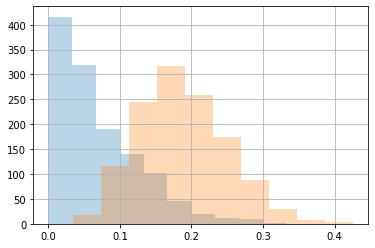

In [63]:
test_df_with_other_preds['top-2-prob-diff'].hist(alpha=0.3)
test_df_with_other_preds['max-prob-diff'].hist(alpha=0.3)

I want to look at the difference between the incorrect top class and the correct class probabilities. First of all - we hope that the second best prediction is the correct one in these cases when the second layer prediction returned other (indicating that something is wrong).

If the difference between the predicted class and the next best is small enough, it might be worth changing your prediction. Figuring out this threshold could be part of training. 

Four scenarios, of which the initial two are the ones we can deal with:
1. False positive - the second layer classifier has screamed "other" even though the top layer classifier was correct. We hope to catch this error through a large difference beteen the predicted cat1 and the other ones
1. True positive - the second layer classifier has secreamed "other" and the top layer classifier is incorrect. Here - we hope the correct class is the second larges one and that this difference is small. 
1. False negative - The second layer does not scream "other" even though we are in the wrong category. Not much we can do here. 
1. True negative - The second layer does not scream "other", because we are in the correct class. 

Correct predictions:   646
Incorrect predictions: 611


<AxesSubplot:>

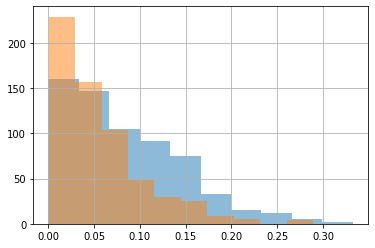

In [64]:
def get_2nd_largest_arg(array):
    array[np.argmax(array)] = -np.inf
    return np.argmax(array)

test_df_with_other_preds['2nd-prediction'] = test_df_with_other_preds.apply(lambda x: class_list[get_2nd_largest_arg(x['probs'])], axis=1)

# Diff between top and correct
correct_preds = test_df_with_other_preds[test_df_with_other_preds["clf3_2_top_1_preds"] == test_df_with_other_preds["Cat1"]]
incorrect_preds = test_df_with_other_preds[test_df_with_other_preds["clf3_2_top_1_preds"] != test_df_with_other_preds["Cat1"]]

print(f"Correct predictions:   {len(correct_preds)}")
print(f"Incorrect predictions: {len(incorrect_preds)}")

correct_preds['top-2-prob-diff'].hist(alpha=0.5)
incorrect_preds['top-2-prob-diff'].hist(alpha=0.5)



Blue: When we've made the correct prediction, the distribution of the "distance" to the second highest prediction probability has a longer tail.

Orange: We've made the incorrect prediction. Here the differences between the predicted class and the second hightest one is smaller (the distribution is more pushed to the left).


In [65]:
#How many times that we've done an incorrect prediction is the correct class the second largest
len(incorrect_preds[incorrect_preds['Cat1'] == incorrect_preds['2nd-prediction']])

338

<AxesSubplot:>

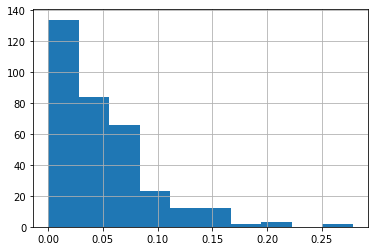

In [66]:
incorrect_preds[incorrect_preds['Cat1'] == incorrect_preds['2nd-prediction']]['top-2-prob-diff'].hist()

In [67]:
def threshold(t, correct_preds, incorrect_preds):
    correct_preds_that_would_be_changed = len(correct_preds[correct_preds["top-2-prob-diff"] > t])
    print(f"With threshold {t}, {correct_preds_that_would_be_changed} correct predictions would be changed to an incorrect one")
    

Going with the second largest probability when model is uncertain might be a step to far. Omly 70 out of the 600+ incorrect predictions have this property. Instead, what we should look at is how to decide if we should remove our guess all together when we've recieved the "other" signal from the classifier below. 

In [68]:
test_df_with_other_preds.head()

,cleaned_text,Cat1,clf3_2_top_1_preds,scores,probs,baby products,beauty,grocery gourmet food,health personal care,pet supplies,toys games,top-2-prob-diff,max-prob-diff,top-correct-prod-diff,2nd-prediction
3841,received kit gift actually use quite bit produ...,baby products,beauty,"[-0.3941265692428392, -0.31537281141210277, -0...","[0.21943465071789586, -inf, 0.1391591904653302...",0.219435,0.237415,0.139159,0.174157,0.068644,0.161190,0.017980,0.168770,0.017980,baby products
36781,tried lot brands found best gripe seem fit 17l...,baby products,health personal care,"[-0.30555314057337823, -1.3351213377482227, -0...","[0.23984366871790153, 0.08566284065240949, 0.1...",0.239844,0.085663,0.163889,0.266569,0.130715,0.113320,0.026726,0.180906,0.026726,baby products
37321,far pleased results took longer thought receiv...,health personal care,health personal care,"[-1.146640166283695, -0.274672393583645, -0.92...","[0.10041972760746205, 0.24016506331904489, 0.1...",0.100420,0.240165,0.125244,0.300100,0.122323,0.111749,0.059935,0.199680,0.000000,beauty
39511,product always satisfies fudge always arrives ...,grocery gourmet food,grocery gourmet food,"[-0.9886334398072809, -1.154359430457858, -0.0...","[0.1163291663347718, 0.09856318580490078, -inf...",0.116329,0.098563,0.299933,0.108764,0.160446,0.215965,0.083967,0.201369,0.000000,toys games
21574,quality much worse dry baby much expensive thi...,baby products,baby products,"[-0.06486857086083886, -1.2902069660233746, -0...","[-inf, 0.0961352727197796, 0.14506286247496614...",0.327371,0.096135,0.145063,0.172716,0.120637,0.138077,0.154655,0.231236,0.000000,health personal care


In [69]:
test_df_with_other_preds['correct_cat1_pred'] = test_df_with_other_preds.apply(lambda x: int(x['Cat1'] == x['clf3_2_top_1_preds']), axis=1)
test_df_with_other_preds.head()

,cleaned_text,Cat1,clf3_2_top_1_preds,scores,probs,baby products,beauty,grocery gourmet food,health personal care,pet supplies,toys games,top-2-prob-diff,max-prob-diff,top-correct-prod-diff,2nd-prediction,correct_cat1_pred
3841,received kit gift actually use quite bit produ...,baby products,beauty,"[-0.3941265692428392, -0.31537281141210277, -0...","[0.21943465071789586, -inf, 0.1391591904653302...",0.219435,0.237415,0.139159,0.174157,0.068644,0.161190,0.017980,0.168770,0.017980,baby products,0
36781,tried lot brands found best gripe seem fit 17l...,baby products,health personal care,"[-0.30555314057337823, -1.3351213377482227, -0...","[0.23984366871790153, 0.08566284065240949, 0.1...",0.239844,0.085663,0.163889,0.266569,0.130715,0.113320,0.026726,0.180906,0.026726,baby products,0
37321,far pleased results took longer thought receiv...,health personal care,health personal care,"[-1.146640166283695, -0.274672393583645, -0.92...","[0.10041972760746205, 0.24016506331904489, 0.1...",0.100420,0.240165,0.125244,0.300100,0.122323,0.111749,0.059935,0.199680,0.000000,beauty,1
39511,product always satisfies fudge always arrives ...,grocery gourmet food,grocery gourmet food,"[-0.9886334398072809, -1.154359430457858, -0.0...","[0.1163291663347718, 0.09856318580490078, -inf...",0.116329,0.098563,0.299933,0.108764,0.160446,0.215965,0.083967,0.201369,0.000000,toys games,1
21574,quality much worse dry baby much expensive thi...,baby products,baby products,"[-0.06486857086083886, -1.2902069660233746, -0...","[-inf, 0.0961352727197796, 0.14506286247496614...",0.327371,0.096135,0.145063,0.172716,0.120637,0.138077,0.154655,0.231236,0.000000,health personal care,1


In [70]:
import matplotlib.pyplot as plt
import sklearn
from scipy.special import expit
from scipy.stats import spearmanr

SpearmanrResult(correlation=0.24988822156219276, pvalue=2.3876067969811125e-19)


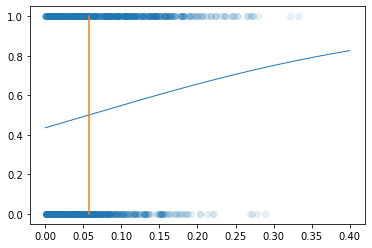

In [73]:
x, y = test_df_with_other_preds["top-2-prob-diff"], test_df_with_other_preds['correct_cat1_pred']
print(spearmanr(x, y))
plt.scatter(x, y, alpha=0.1)

lr_clf = sklearn.linear_model.LogisticRegression()
lr_clf.fit(np.array(x).reshape(-1,1),y)


X_test = np.linspace(0, 0.4, 300).reshape(-1,1)
loss = expit(X_test * lr_clf.coef_ + lr_clf.intercept_).ravel()
plt.plot(X_test, loss, linewidth=1)
plt.plot([0.05752, 0.05752], [0, 1])

Finding the threshold

In [74]:
for i, v in enumerate(loss):
    if v>0.5:
        threshold = X_test[i][0]
        print(threshold)
        break

0.05752508361204014


# Correlation between probability and prediction correctness


In [76]:
train_df.head()

,Title,Text,Cat1,Cat2,cleaned_text,concat_labels,cleaned_title,toys_games-relative_subcat,pet_supplies-relative_subcat,grocery_gourmet_food-relative_subcat,beauty-relative_subcat,health_personal_care-relative_subcat,baby_products-relative_subcat
21721,Little Tikes Discovery Camera Phone,My son seems to like this phone okay. But comp...,toys games,dress up pretend play,son seems like phone okay compared play phones...,toys games/dress up pretend play,little tikes discovery camera phone,dress up pretend play,other,other,other,other,other
15576,"KONG Classic Kong Dog Toy, Red","This is my dog's favorite, not only becuase it...",pet supplies,dogs,dog favorite becuase usually contain food boun...,pet supplies/dogs,kong classic kong dog toy red,other,dogs,other,other,other,other
28716,"Clif Shot Bloks Organic Energy Chews, 2.1-Ounc...",I take these on long runs. I typically don't e...,grocery gourmet food,snack food,take long runs typically eat go blocks curb hu...,grocery gourmet food/snack food,clif shot bloks organic energy chews ounce pac...,other,other,snack food,other,other,other
204,"Pure & Natural Hypoallergenic Bar Soap, 4.5 oz...",Winter is hard on my skin and we've had an exc...,beauty,bath body,winter hard skin exceptionally dry winter skin...,beauty/bath body,pure natural hypoallergenic bar soap oz ea,other,other,other,bath body,other,other
36677,Camille Beckman Hand & Shower Gel,I bought the 8oz White lilac shower gel and I ...,beauty,bath body,bought 8oz white lilac shower gel love foams r...,beauty/bath body,camille beckman hand shower gel,other,other,other,bath body,other,other
